In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
from sklearn.preprocessing import MinMaxScaler
import scipy.spatial.distance as dist
import itertools
import math
import warnings
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import av
from multiprocessing import Pool
import functools
import glob
plt.rcParams['animation.ffmpeg_path']='/home/jma819/.conda/envs/caiman/bin/ffmpeg'
warnings.filterwarnings(action='once')

In [2]:
reload(utils_jjm)
reload(dlc_utils)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
##wt files 
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']
##ko files 
ko_sessions = ['GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN018_H17_M41_S43',
 'GRIN018_H16_M13_S53', 'GRIN011_H10_M19_S59', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

In [4]:
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/compiled_data/GRIN009_H13_M59_S14_.h5')
keys=h5file.keys()
h5file.close()

In [5]:
keys

['/GRIN009_H13_M59_S14C',
 '/GRIN009_H13_M59_S14C_normalized',
 '/GRIN009_H13_M59_S14C_normalized_z_scored',
 '/GRIN009_H13_M59_S14com_df',
 '/GRIN009_H13_M59_S14velocity_data']

In [6]:
grouped_raw_data = {}
for session in wt_sessions+ko_sessions:
    h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/compiled_data/'+session+'_.h5')
    keys=h5file.keys()
    h5file.close()
    raw_session_data = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/compiled_data/'+session+'_.h5', key=key_idx) for key_idx in keys}
    grouped_raw_data[session] = raw_session_data     

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()


In [7]:
#grouped_raw_data['GRIN039_H14_M8_S53']['GRIN039_H14_M8_S53C']

In [8]:
#load spatial components 
spatial_h5file=h5py.File('/projects/b1118/miniscope/analysis/spatial_data/spatial_components_test.h5', 'r')
spatial_contours = {session:spatial_h5file[session][:] for session in list(spatial_h5file.keys())}
spatial_h5file.close()

In [12]:
##wt files 
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']

#ko files
ko_sessions = ['GRIN011_H10_M19_S59', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23',  
               'GRIN018_H17_M41_S43', 'GRIN018_H16_M13_S53', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

## find bursting periods 

In [25]:
##remove small cells 
filtered_for_analysis = {}

for session in list(grouped_raw_data.keys()):
    # get indicies of small cells 
    cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_contours[session])
    cells_to_drop = np.array([int(cell) for cell in list(for_dims.keys()) if 
                              len(np.array(np.where(for_dims[cell]>0.6)[0]))<100])

    C_traces_filtered = grouped_raw_data[session][session+'C_normalized_z_scored'].drop(cells_to_drop, axis=1)
    filtered_for_analysis[session] = C_traces_filtered.drop('msCamFrame', axis=1)
    
    

In [40]:
wt_cells = {session:len(filtered_for_analysis[session].columns) for session in wt_sessions}
ko_cells = {session:len(filtered_for_analysis[session].columns) for session in ko_sessions}
all_cells = {session:len(filtered_for_analysis[session].columns) for session in wt_sessions+ko_sessions}

In [38]:
np.mean(list(wt_cells.values()))

68.75

In [39]:
np.mean(list(ko_cells.values()))

89.45454545454545

In [41]:
np.mean(list(all_cells.values()))

77.18518518518519

In [83]:
new_sampling_interval = .2    
# sets sampling interval to 5Hz 
C_norm_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(filtered_for_analysis.keys())], axis=1, keys=list(filtered_for_analysis.keys()))
# after downsampling convert back to regular index
C_norm_df_reindexed = pd.concat([C_norm_df[session].reset_index(drop=True)
                  for session in list(set(C_norm_df.columns.get_level_values(0)))], axis=1, keys=list(set(C_norm_df.columns.get_level_values(0))))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:19:04.820693. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [38]:
# bin/binarize cell activity 
session = 'GRIN038_H15_M39_S40'
samples_to_forward_smooth = 5
z_score_threshold = 2.5
binned_session = C_norm_df_reindexed[session].apply(utils_jjm.binning_function_uncrop, 
                                                                  axis=0, args=(samples_to_forward_smooth, z_score_threshold))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-22 22:03:18.899316. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-22 22:03:21.360700. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


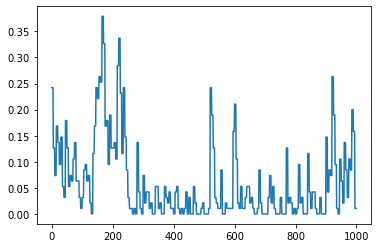

In [39]:
bounds_of_bursting_session = (0, 1000)
plt.plot((binned_session.sum(axis=1)/len(binned_session.columns))[bounds_of_bursting_session[0]:bounds_of_bursting_session[1]])

In [40]:
#store a list of active cells at each sample point 
active_cells_by_time = {}
for sample in list(binned_session[bounds_of_bursting_session[0]:bounds_of_bursting_session[1]].index):
    active_cells_by_time[sample]=[]
    for cell in list(binned_session.columns):
        if binned_session[bounds_of_bursting_session[0]:bounds_of_bursting_session[1]].loc[sample][cell]==1:
            active_cells_by_time[sample].append(cell)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-22 22:03:50.711732. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [46]:
# load spatial data and get average distance bewtween coactive cells 

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 13:48:36.974118. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [49]:
cell_com = pd.read_csv('/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/jones_script_analysis/GRIN011_H10_M19_S59_com_filtered.csv')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 13:59:00.632154. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [76]:
avg_distance_coactive_cell_by_sample = []
for sample in tqdm(list(active_cells_by_time.keys())):
    cell_distances = []
    for pair in itertools.combinations(active_cells_by_time[sample], 2):
        cell_distances.append(math.sqrt((cell_com[str(pair[0])][0]-cell_com[str(pair[1])][0])**2+(cell_com[str(pair[0])][1]-cell_com[str(pair[1])][1])**2))    
    avg_distance_coactive_cell_by_sample.append(np.mean(cell_distances))
avg_distance_coactive_cell_by_sample = np.array(avg_distance_coactive_cell_by_sample)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 14:32:01.301682. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
100%|██████████| 1000/1000 [00:04<00:00, 209.61it/s]


In [81]:
np.nan_to_num(avg_distance_coactive_cell_by_sample, copy=False, nan=0.0)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 14:33:34.917447. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([165.31390512, 165.31390512, 165.31390512, 165.31390512,
       165.31390512, 165.31390512, 165.31390512, 165.31390512,
       165.31390512, 165.31390512,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       218.08545292, 218.08545292, 218.08545292, 218.08545292,
       218.08545292, 218.08545292, 218.08545292, 218.08545292,
       218.08545292, 218.08545292, 191.30774258, 191.30774258,
       191.30774258, 191.30774258, 191.30774258, 191.30774258,
       191.30774258, 191.30774258, 191.30774258, 191.30774258,
       225.05030121, 225.05030121, 225.05030121, 225.05030121,
       225.05030121, 225.05030121, 225.05030121, 225.05030121,
       225.05030121, 225.05030121,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       182.56854316, 182.56854316, 182.56854316, 182.56

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 14:33:35.444418. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


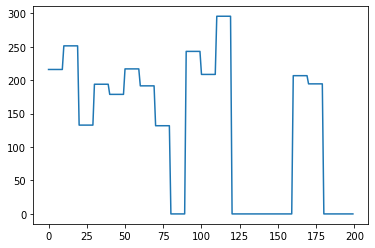

In [82]:
plt.plot(avg_distance_coactive_cell_by_sample[200:400])

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-21 14:33:55.382356. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


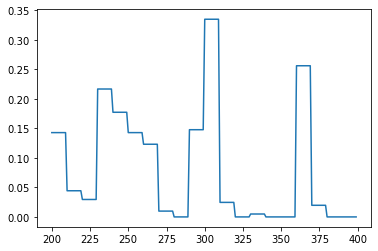

In [84]:
#plt.plot((binned_session.sum(axis=1)/len(binned_session.columns))[bounds_of_bursting_session[0]:bounds_of_bursting_session[1]])
plt.plot((binned_session.sum(axis=1)/len(binned_session.columns))[200:400])

In [ ]:
##could do this over entire trace to get sets of coactive cells ?? 
#then look for large sets of coactivity (greater than 5?)
#get total set of individual cells active during periods of coacticity
#for each cell in the set, plot the similarity of other cells it was coactive with across all periods
#i.e. is this cell always part of the same "cluster"


In [23]:
C_norm_df_reindexed.columns.levels[0]

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-22 10:57:51.149640. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


27

In [41]:
# bin/binarize cell activity 
for session in list(C_norm_df_reindexed.columns.levels[0]):
    samples_to_forward_smooth = 10
    z_score_threshold = 2.5
    binned_session = C_norm_df_reindexed[session].apply(utils_jjm.binning_function_uncrop, 
                                                                  axis=0, args=(samples_to_forward_smooth, z_score_threshold))

    cell_com = pd.read_csv('/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/jones_script_analysis/'+session+'_com_filtered.csv')

    #get lists of cell active during sample periods in a given session
    active_cells_by_time_whole_session = {}
    for sample in tqdm(list(binned_session.index)):
        active_cells_by_time_whole_session[sample]=[]
        for cell in list(binned_session.columns):
            if binned_session.loc[sample][cell]==1:
                active_cells_by_time_whole_session[sample].append(cell)

    #get the average distance between all cell pairs active during each sample 
    avg_distance_coactive_cell_by_sample = []
    for sample in tqdm(list(active_cells_by_time_whole_session.keys())):
        cell_distances = []
        for pair in itertools.combinations(active_cells_by_time_whole_session[sample], 2):
            cell_distances.append(math.sqrt((cell_com[str(pair[0])][0]-cell_com[str(pair[1])][0])**2+(cell_com[str(pair[0])][1]-cell_com[str(pair[1])][1])**2))    
        avg_distance_coactive_cell_by_sample.append(np.mean(cell_distances))
    avg_distance_coactive_cell_by_sample = np.array(avg_distance_coactive_cell_by_sample)

    ## save the lists of active cells and the average cluster distance per sample to h5 files
    h5_output = h5py.File('/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/cluster_size/'+session+'_082021_clusters.h5', 'w')
    for sample in list(active_cells_by_time_whole_session.keys()):
        sub_grp = h5_output.create_group(str(sample)) 
        sub_grp.create_dataset('active cells', data=np.array(active_cells_by_time_whole_session[sample]))
    h5_output.create_dataset('average cell distance of active cells', data=avg_distance_coactive_cell_by_sample)
    h5_output.close()
    print('saved'+session)



/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-22 22:05:04.771291. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
  0%|          | 0/10785 [00:00<?, ?it/s]/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10785/10785 [00:02<00:00, 4183.19it/s] 


savedGRIN018_H16_M13_S53


  5%|▍         | 498/10785 [00:00<00:02, 4979.02it/s]

savedGRIN012_H17_M32_S17


100%|██████████| 10785/10785 [00:00<00:00, 78475.39it/s]


savedGRIN041_H12_M54_S49


  0%|          | 0/10785 [00:00<?, ?it/s]

savedGRIN009_H13_M59_S14


100%|██████████| 10785/10785 [00:00<00:00, 36276.27it/s]


savedGRIN039_H12_M33_S29


100%|██████████| 10785/10785 [00:34<00:00, 312.89it/s]


savedGRIN038_H13_M37_S23


100%|██████████| 10785/10785 [00:05<00:00, 1877.95it/s]


savedGRIN035_H13_M31_S20


100%|██████████| 10785/10785 [00:09<00:00, 1142.56it/s]


savedGRIN035_H13_M50_S58


100%|██████████| 10785/10785 [00:09<00:00, 1095.82it/s]


savedGRIN039_H14_M8_S53


100%|██████████| 10785/10785 [00:09<00:00, 1149.57it/s]


savedGRIN026_H16_M35_S34


100%|██████████| 10785/10785 [00:04<00:00, 2190.06it/s]


savedGRIN018_H17_M41_S43


100%|██████████| 10785/10785 [00:01<00:00, 6248.75it/s]


savedGRIN013_H13_M33_S54


100%|██████████| 10785/10785 [00:01<00:00, 9423.07it/s]


savedGRIN034_H19_M0_S18


100%|██████████| 10785/10785 [00:06<00:00, 1627.52it/s]


savedGRIN039_H12_M26_S54


100%|██████████| 10785/10785 [00:13<00:00, 786.90it/s]


savedGRIN032_H16_M49_S22


100%|██████████| 10785/10785 [00:02<00:00, 3671.90it/s]


savedGRIN027_H13_M29_S44


100%|██████████| 10785/10785 [00:25<00:00, 417.12it/s] 


savedGRIN032_H17_M30_S22


100%|██████████| 10785/10785 [00:57<00:00, 186.35it/s]


savedGRIN011_H10_M19_S59


100%|██████████| 10785/10785 [00:07<00:00, 1461.93it/s]


savedGRIN012_H16_M57_S23


100%|██████████| 10785/10785 [00:00<00:00, 12379.40it/s]


savedGRIN034_H16_M13_S22


100%|██████████| 10785/10785 [00:08<00:00, 1254.10it/s]


savedGRIN038_H15_M39_S40


100%|██████████| 10785/10785 [00:16<00:00, 666.71it/s]


savedGRIN033_H13_M42_S33


100%|██████████| 10785/10785 [00:03<00:00, 3517.70it/s]


savedGRIN034_H15_M28_S2


100%|██████████| 10785/10785 [00:01<00:00, 10348.12it/s]


savedGRIN033_H14_M34_S32


100%|██████████| 10785/10785 [00:09<00:00, 1096.74it/s]


savedGRIN035_H14_M40_S34


  2%|▏         | 206/10785 [00:00<00:05, 2051.34it/s]

savedGRIN038_H11_M57_S0


100%|██████████| 10785/10785 [00:00<00:00, 57532.14it/s]


savedGRIN012_H17_M46_S35


In [ ]:
##analyze cluster sizes by genotype 

In [14]:
def concat_by_mouse(df_unsorted):
    sorted_by_mouse = {mouse:[] for mouse in list(set([session[0:7] for session in list(df_unsorted.columns)]))}
    for mouse in sorted_by_mouse.keys():
        for session in list(df_unsorted.columns):
            if session[0:7] == mouse:
                sorted_by_mouse[mouse].append(df_unsorted[session])
    concat_by_mouse_df = pd.DataFrame({mouse:pd.concat(sorted_by_mouse[mouse], axis=1).mean(axis=1) for mouse in list(sorted_by_mouse.keys())})
    return(concat_by_mouse_df)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 14:56:54.730879. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [11]:
##wt files 
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']

#ko files
ko_sessions = ['GRIN011_H10_M19_S59', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23',  
               'GRIN018_H17_M41_S43', 'GRIN018_H16_M13_S53', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
cluster_files = glob.glob('/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/cluster_size/*_clusters.h5')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:07:49.364868. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
saved_cluster_info = {}
for file in cluster_files:
    f = h5py.File(file, 'r')
    saved_cluster_info[file.split('/')[-1].strip('_clusters.h5')]=f['average cell distance of active cells'][:]
    f.close()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:07:53.701614. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [61]:
list(saved_cluster_info.keys())[0:10]

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:10:11.619068. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


['GRIN034_H15_M28_S2_082021',
 'GRIN018_H17_M41_S43',
 'GRIN035_H13_M50_S58_082021',
 'GRIN032_H16_M49_S22_082021',
 'GRIN032_H17_M30_S22_082021',
 'GRIN033_H14_M34_S32_082021',
 'GRIN018_H17_M41_S43_082021',
 'GRIN033_H13_M42_S33',
 'GRIN035_H13_M31_S20',
 'GRIN035_H14_M40_S34']

In [70]:
avgs_clusters_per_session_wt = pd.DataFrame({k:v for k,v in zip([session for session in list(saved_cluster_info.keys())], 
                                             [np.nanmean(cluster_size) for cluster_size in list(saved_cluster_info.values())]) if
                             k in wt_sessions}, index=['avgdistance'])
avgs_clusters_per_session_ko = pd.DataFrame({k:v for k,v in zip([session for session in list(saved_cluster_info.keys())], 
                                             [np.nanmean(cluster_size) for cluster_size in list(saved_cluster_info.values())]) if
                             k in ko_sessions}, index=['avgdistance'])
by_mouse_wt = concat_by_mouse(avgs_clusters_per_session_wt)
by_mouse_ko = concat_by_mouse(avgs_clusters_per_session_ko)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:13:03.773228. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
avgs_clusters_per_session_wt

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:13:06.592413. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,GRIN033_H13_M42_S33,GRIN035_H13_M31_S20,GRIN035_H14_M40_S34,GRIN039_H12_M33_S29,GRIN034_H19_M0_S18,GRIN039_H12_M26_S54,GRIN027_H13_M29_S44,GRIN034_H16_M13_S22,GRIN032_H17_M30_S22,GRIN039_H14_M8_S53,GRIN035_H13_M50_S58,GRIN026_H16_M35_S34,GRIN033_H14_M34_S32,GRIN034_H15_M28_S2,GRIN032_H16_M49_S22,GRIN013_H13_M33_S54
avgdistance,136.466047,151.680949,142.070071,136.604259,198.306641,95.96699,120.196086,210.300136,162.458412,139.826366,135.776629,145.306098,151.810463,170.738538,152.995798,118.476005


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:13:17.997843. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


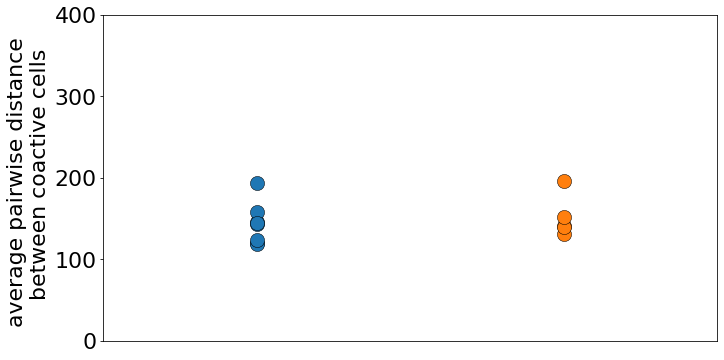

In [73]:
plt.rcParams.update({'font.size': 22})
plt.scatter(np.zeros(len(by_mouse_wt.loc['avgdistance'])), by_mouse_wt.loc['avgdistance'], s=200, 
            linewidths=0.5, edgecolors='k')
plt.scatter(np.ones(len(by_mouse_ko.loc['avgdistance']))/2, by_mouse_ko.loc['avgdistance'], s=200, 
            linewidths=0.5, edgecolors='k')
plt.ylim((0, 400))
plt.xlim((-0.25, 0.75))
fig = plt.gcf()
fig.set_size_inches(11, 6)
ax = plt.gca()
ax.set_ylabel('average pairwise distance \n between coactive cells')
ax.axes.get_xaxis().set_visible(False)
fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/avg_pairwise_distance_session.pdf', transparent=True)
plt.show()

In [74]:
##plot cumulative distribution of cluster sizes 

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:13:37.845469. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
clusters_per_session_wt = {k:v for k,v in zip([session for session in list(saved_cluster_info.keys())], 
                                             [cluster_size for cluster_size in list(saved_cluster_info.values())]) if
                             k in wt_sessions}
clusters_per_session_ko = {k:v for k,v in zip([session for session in list(saved_cluster_info.keys())], 
                                             [cluster_size for cluster_size in list(saved_cluster_info.values())]) if
                             k in ko_sessions}

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:13:39.100545. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [95]:
np.hstack(list(clusters_per_session_wt.values())[i][np.logical_not(np.isnan(list(clusters_per_session_wt.values())[i]))] for i in range(len(clusters_per_session_wt.keys())))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:31:31.880593. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
<ipython-input-95-cb0368ea41ce>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  len(np.hstack(list(clusters_per_session_wt.values())[i][np.logical_not(np.isnan(list(clusters_per_session_wt.values())[i]))] for i in range(len(clusters_per_session_wt.keys()))))


67320

In [96]:
all_cluster_sizes_wt = np.hstack(list(clusters_per_session_wt.values())[i][np.logical_not(np.isnan(list(clusters_per_session_wt.values())[i]))] for i in range(len(clusters_per_session_wt.keys())))
#all_cluster_sizes_wt = np.nan_to_num(all_cluster_sizes_wt, nan=0.0)
all_cluster_sizes_ko = np.hstack(list(clusters_per_session_ko.values())[i][np.logical_not(np.isnan(list(clusters_per_session_ko.values())[i]))] for i in range(len(clusters_per_session_ko.keys())))
#all_cluster_sizes_ko = np.nan_to_num(all_cluster_sizes_ko, nan=0.0)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:32:49.953805. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
<ipython-input-96-0adc22b3c098>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_cluster_sizes_wt = np.hstack(list(clusters_per_session_wt.values())[i][np.logical_not(np.isnan(list(clusters_per_session_wt.values())[i]))] for i in range(len(clusters_per_session_wt.keys())))


In [97]:
all_wt_clusters_cumulative = stats.cumfreq(all_cluster_sizes_wt, numbins=500, defaultreallimits=(0, 300))
all_ko_clusters_cumulative = stats.cumfreq(all_cluster_sizes_ko, numbins=500, defaultreallimits=(0, 300))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:32:50.845566. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [98]:
wt_data = all_wt_clusters_cumulative.cumcount/len(all_cluster_sizes_wt)
ko_data = all_ko_clusters_cumulative.cumcount/len(all_cluster_sizes_ko)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:32:51.789878. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:32:52.461966. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


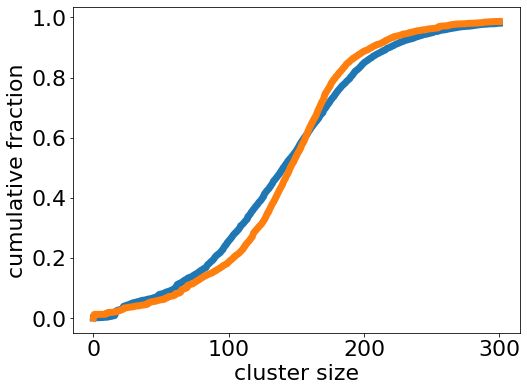

In [99]:
plt.plot(np.linspace(0, 300, 500), wt_data, linewidth=7.0)
plt.plot(np.linspace(0, 300, 500), ko_data, linewidth=7.0)
fig = plt.gcf()
fig.set_size_inches(8, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('cluster size')
fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/cumulative_cluster_size.pdf', transparent=True)
plt.show()

In [80]:
## just analyze cell activity 

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:14:38.593817. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
C_norm_df_reindexed

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 15:37:46.844151. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GRIN038_H11_M57_S0                                                    \
                     1         2         3         4         5         6     
0               0.030641 -0.334673 -0.385941  1.378682  0.415051  1.787543   
1               0.006106  0.530134 -0.482426  0.829074  0.406346  1.471651   
2              -0.044704  0.372799  0.219029  0.052913  0.271380  1.123980   
3              -0.085678  0.109389  0.495987  0.271491  0.102831  1.000351   
4              -0.118721 -0.097926  0.095145 -0.044795 -0.103111  0.610818   
...                  ...       ...       ...       ...       ...       ...   
10780                NaN       NaN       NaN       NaN       NaN       NaN   
10781                NaN       NaN       NaN       NaN       NaN       NaN   
10782                NaN       NaN       NaN       NaN       NaN       NaN   
10783                NaN       NaN       NaN       NaN       NaN       NaN   
10784                NaN       NaN       NaN       NaN       NaN       NaN   

                                               ... GRIN035_H13_M31_S20  \
            7         9         10        11   ...                 92    
0     -0.796210 -0.095890 -0.670173  0.250826  ...           -0.874208   
1     -0.815548 -0.050909 -0.435981  0.496721  ...           -0.874208   
2      0.012096  0.032167 -0.426361  0.434462  ...           -0.874208   
3     -0.212388 -0.007789 -0.315667  2.210106  ...           -0.874208   
4     -0.501097 -0.070250 -0.350987  2.201244  ...           -0.874208   
...         ...       ...       ...       ...  ...                 ...   
10780       NaN       NaN       NaN       NaN  ...                 NaN   
10781       NaN       NaN       NaN       NaN  ...                 NaN   
10782       NaN       NaN       NaN       NaN  ...                 NaN   
10783       NaN       NaN       NaN       NaN  ...                 NaN   
10784       NaN       NaN       NaN       NaN  ...                 NaN   

                                                                             \
            94        95        96        97        98        99        100   
0     -0.884617 -0.398490 -0.783585 -0.302336  0.950614 -0.298345 -0.668222   
1     -0.836608 -0.409878 -0.787458 -0.335660  1.075597 -0.362013 -0.235355   
2     -0.781434 -0.374840 -0.800570 -0.325061  1.511132 -0.417915 -0.362256   
3     -0.823737 -0.329160 -0.810561 -0.332034  1.028973 -0.466998 -0.454513   
4     -0.884786 -0.346194 -0.818176 -0.336874  1.261573 -0.510095 -0.521586   
...         ...       ...       ...       ...       ...       ...       ...   
10780       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10781       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10782       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10783       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10784       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                           
            103       115  
0     -0.175693 -0.116727  
1     -0.174399 -0.116727  
2     -0.172158 -0.116727  
3     -0.173499 -0.116727  
4     -0.170579 -0.116727  
...         ...       ...  
10780       NaN       NaN  
10781       NaN       NaN  
10782       NaN       NaN  
10783       NaN       NaN  
10784       NaN       NaN  

[10785 rows x 2084 columns]

In [111]:
# bin/binarize cell activity 
ISIs_by_session = {}
for session in tqdm(list(C_norm_df_reindexed.columns.levels[0])):
    samples_to_forward_smooth = 1
    z_score_threshold = 2.5
    binned_session = C_norm_df_reindexed[session].apply(utils_jjm.binning_function_uncrop, 
                                                                  axis=0, args=(samples_to_forward_smooth, z_score_threshold))
    ISIs_by_cell = utils_jjm.get_ISIs_binned_data(np.transpose(binned_session.values), 5, len(np.transpose(binned_session.values)), 0.5)
    ISIs_in_session = np.hstack([np.array(ISI_list) for ISI_list in ISIs_by_cell[0]])
    ISIs_by_session[session] = ISIs_in_session

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 16:01:38.587056. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
100%|██████████| 27/27 [02:16<00:00,  5.05s/it]


In [112]:
ISIs_by_session_wt = {k:v for k,v in zip(ISIs_by_session.keys(),ISIs_by_session.values()) if k in wt_sessions}
ISIs_by_session_ko = {k:v for k,v in zip(ISIs_by_session.keys(),ISIs_by_session.values()) if k in ko_sessions}

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 16:07:11.371114. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [113]:
all_wt_ISIs = np.hstack([ISIs for ISIs in ISIs_by_session_wt.values()])
all_ko_ISIs = np.hstack([ISIs for ISIs in ISIs_by_session_ko.values()])

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 16:07:12.494060. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [114]:
all_wt_ISIs_cumulative = stats.cumfreq(all_wt_ISIs, numbins=1000, defaultreallimits=(0, 1800))
wt_data = all_wt_ISIs_cumulative.cumcount/len(all_wt_ISIs)
all_ko_ISIs_cumulative = stats.cumfreq(all_ko_ISIs, numbins=1000, defaultreallimits=(0, 1800))
ko_data = all_ko_ISIs_cumulative.cumcount/len(all_ko_ISIs)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 16:07:13.187050. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-08-23 16:07:13.952798. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


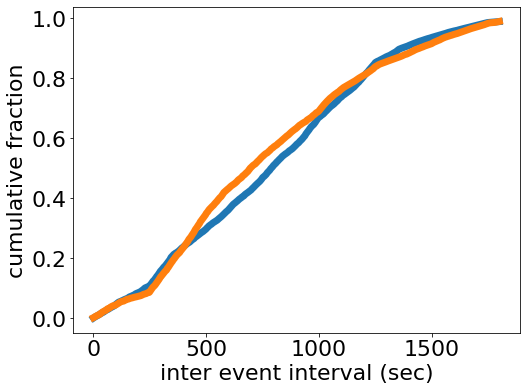

In [115]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 1800, 1000), wt_data, linewidth=7.0)
plt.plot(np.linspace(0, 1800, 1000), ko_data, linewidth=7.0)
fig = plt.gcf()
fig.set_size_inches(8, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('inter event interval (sec)')
fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/event_ISIs.pdf', transparent=True)
plt.show()